In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import re
import squarify

from utils import *
from matplotlib import pyplot as plt
from pymongo import MongoClient
from textwrap import wrap

### Parâmetros do matplot e Seaborn

In [2]:
%matplotlib inline
pd.options.mode.chained_assignment = None 
plt.rcParams['figure.figsize'] = [10, 5]
sns.set(rc={'figure.figsize':(15,10)})

### Recuperação de Datasets do MongoDB

In [3]:
df_tipos_infracoes_2018 = mongo_to_dataframe("tipos_infracoes_2018")

In [3]:
df_infracoes_prf_2010_2018 = mongo_to_dataframe("infracoes_prf_2010_2018")

In [4]:
df_infracoes_der_2018_2019 = mongo_to_dataframe("infracoes_der_2018_2019")

In [6]:
df_acidentes_fatais_2008_2017 = mongo_to_dataframe("acidentes_fatais_2008_2017")

In [7]:
df_acidentes_rodovias_2010_2019 = mongo_to_dataframe("acidentes_rodovias_2010_2019")

### Preparação dos dados

In [5]:
def get_periodo(row, horario_column):
    
    horario = wrap(row[horario_column], 2)[0]
    
    if row[horario_column] == 'NAO_ESPECIFICADA':
        return 'NAO_ESPECIFICADA'
    elif horario >= '06' and horario < '12':
        return 'Amanhecer'
    elif horario >= '12' and horario < '18':
        return 'Pleno dia'
    elif horario >= '18' and horario < '19':
        return 'Anoitecer'
    elif horario >= '19' and horario <= '23':
        return 'Plena Noite'
    elif horario >= '00' and horario <= '06':
        return 'Madrugada'

#### PRF

In [6]:
columns_to_drop = ['ind_assinou_auto', 'ind_veiculo_estrangeiro', 'ind_veiculo_estrangeiro', 'ind_sentido_trafego', 'uf_placa', 'uf_infracao', 'nom_municipio', 'enquadramento', 'data_inicio_vigencia', 'data_fim_vigencia', 'med_realizada', 'med_considerada', 'exc_verificado']

df_infracoes_prf_2010_2018.descricao_abreviada = df_infracoes_prf_2010_2018.descricao_abreviada.str.strip()
df_infracoes_prf_2010_2018.hora = df_infracoes_prf_2010_2018.hora.str.strip()
df_infracoes_prf_2010_2018['fase_dia'] = df_infracoes_prf_2010_2018.apply(lambda row: get_periodo(row, 'hora'), axis = 1)
df_infracoes_prf_2010_2018.dat_infracao = pd.to_datetime(df_infracoes_prf_2010_2018.dat_infracao)
df_infracoes_prf_2010_2018 = df_infracoes_prf_2010_2018.drop(columns_to_drop, axis = 1)
df_infracoes_prf_2010_2018.tip_abordagem = df_infracoes_prf_2010_2018.tip_abordagem.str.strip()
df_infracoes_prf_2010_2018 = df_infracoes_prf_2010_2018.replace({'S':'Fiscalizacao Eletronica', 'C': 'Fiscalizacao Policial'})

In [ ]:
df_acidentes_rodovias_2010_2019 = df_acidentes_rodovias_2010_2019[df_acidentes_rodovias_2010_2019.classificacao_acidente == 'Com Vítimas Fatais']
df_acidentes_rodovias_2010_2019['fase_dia'] = df_acidentes_rodovias_2010_2019.apply(lambda row: get_periodo(row, 'horario'), axis = 1)

#### DER

In [8]:
columns_to_drop = ['auinf_local_km', 'auinf_local_referencia', 'auinf_local_complemento', 'auinf_local_latitude', 'auinf_local_longitude']

df_infracoes_der_2018_2019 = df_infracoes_der_2018_2019.drop(columns_to_drop, axis = 1)
df_infracoes_der_2018_2019.descricao = df_infracoes_der_2018_2019.descricao.str.strip()
df_infracoes_der_2018_2019.cometimento = df_infracoes_der_2018_2019.cometimento.str.strip() 
df_infracoes_der_2018_2019['fase_dia'] = df_infracoes_der_2018_2019.apply(lambda row: get_periodo(row, 'hora_cometimento'), axis = 1)
df_infracoes_der_2018_2019.cometimento = pd.to_datetime(df_infracoes_der_2018_2019.cometimento)

In [12]:
df_acidentes_fatais_2008_2017['fase_dia'] = df_acidentes_fatais_2008_2017.apply(lambda row: get_periodo(row, 'Hora'), axis = 1)

### Observações (H 07)

* PRF
    * Número de infrações durante madrugadas é baixo nos registros da PRF
    * Nas BRs o número de infrações registradas por equipamentos eletrônicos durante as madrugadas é maior que no anoitecer (possível desenvolvimento de altas velocidades)
    * A hipótese de que o desenvolvimento de altas velocidades ocorre durante a noite foi refutada para os registros da PRF.
    * A grande parte das infrações registradas pela PRF (mesmo as agrupadas somente por velocidade) ocorrem durante o amanhecer e pleno dia.
    * A maior parte dos registros de infrações relacionadas ao álcool não tem hora especificada.
    * Apesar da observação anterior, a maioria dos registros de infrações relacionadas ao álcool que tem horário especificado ocorre durante a noite.
    * Madrugadas tem menos infrações relacionadas ao álcool do que o dia (Possível falta de fiscalização da PRF?)
    * Falta de especificação de hora nos registros eletrônicos pode identificar possíveis falhas dos equipamentos ou gerenciamento da base de dados da polícia rodoviária.

* DER
    * Hipótese refutada, no geral as infrações por ultrapassar o limite de velocidade também se concentram durante o período do dia.
    * Hipótese confirmada para registros de infrações ligadas ao ácool, que se concentram, em sua maior parte, durante o período da madrugada, seguida pelo período da plena noite (registros DER).
    * Esforços para a concentração de fiscalização durante os períodos das madrugadas e noites resultam de fato em um número maior de infrações ligadas ao álcool.
    * Infrações ligadas ao álcool crescem do primeiro ao último dia do final de semana.

Text(0.5, 1.0, 'Infrações por período - PRF')

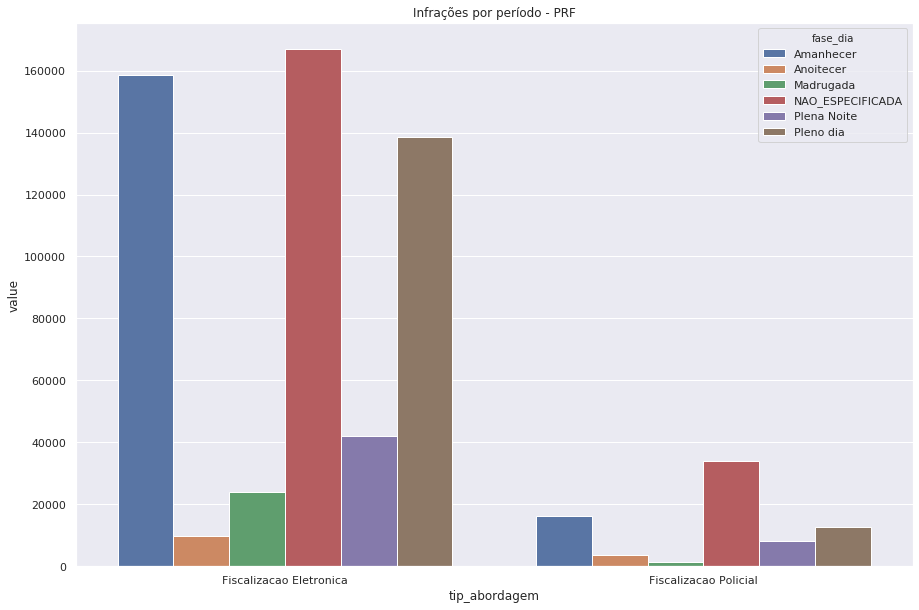

In [13]:
infracoes_por_periodo_prf = df_infracoes_prf_2010_2018.groupby(['tip_abordagem', 'fase_dia']).size().unstack().reset_index()
infracoes_por_periodo_prf = infracoes_por_periodo_prf.melt(id_vars = ['tip_abordagem'], value_vars = ['Amanhecer', 'Anoitecer', 'Madrugada', 'NAO_ESPECIFICADA', 'Plena Noite', 'Pleno dia'])

sns.barplot(data = infracoes_por_periodo_prf, x = 'tip_abordagem', y = 'value', hue = 'fase_dia')
plt.title('Infrações por período - PRF')

Text(0.5, 1.0, 'Total de infrações por período - PRF')

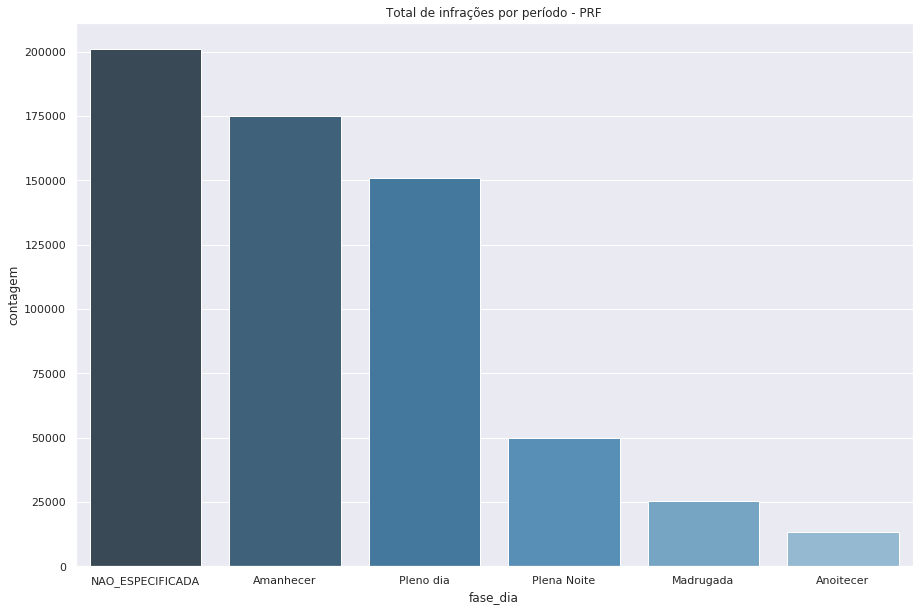

In [16]:
infracoes_por_periodo_prf = df_infracoes_prf_2010_2018.groupby(['fase_dia']).size().reset_index(name = 'contagem').\
                            sort_values('contagem', ascending = False)

sns.barplot(data = infracoes_por_periodo_prf, x = 'fase_dia', y = 'contagem', palette = 'Blues_d')
plt.title('Total de infrações por período - PRF')

Text(0.5, 1.0, 'Total de infrações de limite de velocidade por período - PRF')

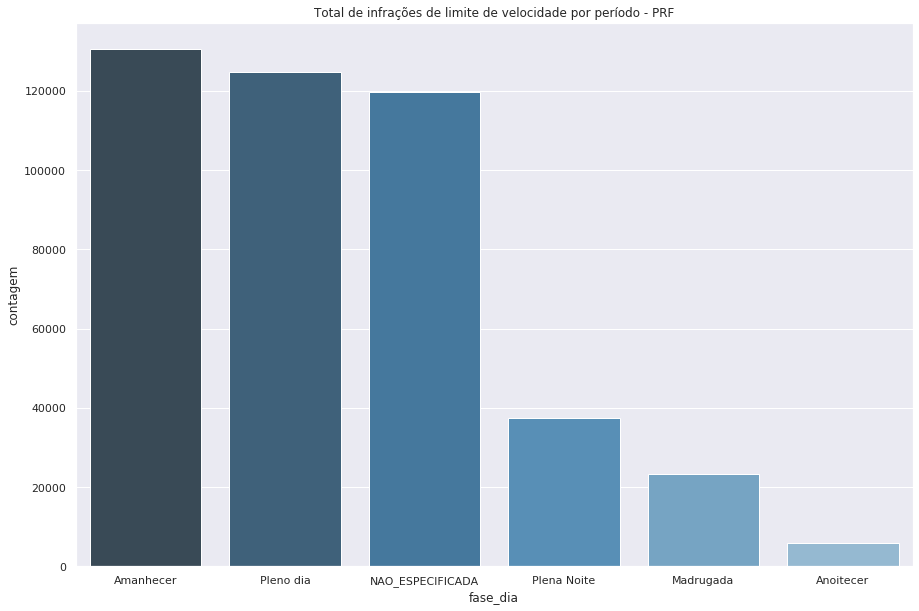

In [17]:
lista_infracoes_alta_velocidade = ['Transitar em velocidade superior à máxima permitida em até 20%', 'Transitar em velocidade superior à máxima permitida em mais de 20% até 50%', 'Transitar em velocidade superior à máxima permitida em mais de 50%']

infracoes_por_periodo_prf = df_infracoes_prf_2010_2018[df_infracoes_prf_2010_2018.descricao_abreviada.isin(lista_infracoes_alta_velocidade)]
infracoes_por_periodo_prf = infracoes_por_periodo_prf.groupby(['fase_dia']).size().reset_index(name = 'contagem').\
                            sort_values('contagem', ascending = False)

sns.barplot(data = infracoes_por_periodo_prf, x = 'fase_dia', y = 'contagem', palette = 'Blues_d')
plt.title('Total de infrações de limite de velocidade por período - PRF')

Text(0.5, 1.0, 'Total de infrações de dirigir sob infuência de ácool por período - PRF')

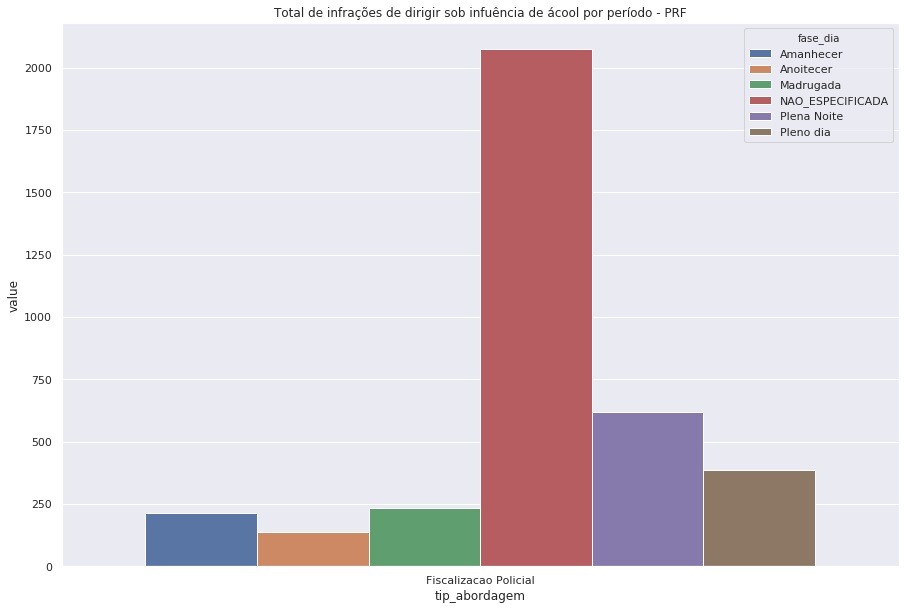

In [18]:
lista_infracoes_alcool = ['Rec sub test,ex clin, peric ou proc q perm cert infl alc/sub. psic for art.277', 'Dirigir sob a influência de álcool']

infracoes_por_periodo_prf = df_infracoes_prf_2010_2018[df_infracoes_prf_2010_2018.descricao_abreviada.isin(lista_infracoes_alcool) ]
infracoes_por_periodo_prf = infracoes_por_periodo_prf.groupby(['tip_abordagem', 'fase_dia']).size().unstack().reset_index()
infracoes_por_periodo_prf = infracoes_por_periodo_prf.melt(id_vars = ['tip_abordagem'], value_vars = ['Amanhecer', 'Anoitecer', 'Madrugada', 'NAO_ESPECIFICADA', 'Plena Noite', 'Pleno dia'])

sns.barplot(data = infracoes_por_periodo_prf, x = 'tip_abordagem', y = 'value', hue = 'fase_dia')
plt.title('Total de infrações de dirigir sob infuência de ácool por período - PRF')

Text(0.5, 1.0, 'Total de infrações de dirigir sob infuência de ácool por período - PRF')

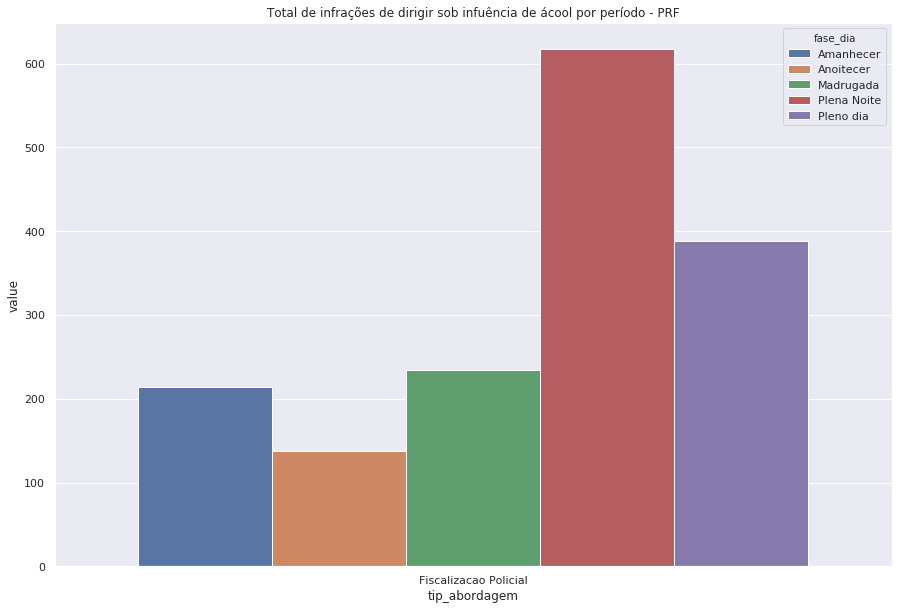

In [19]:
infracoes_por_periodo_prf = infracoes_por_periodo_prf[infracoes_por_periodo_prf.fase_dia != 'NAO_ESPECIFICADA']
sns.barplot(data = infracoes_por_periodo_prf, x = 'tip_abordagem', y = 'value', hue = 'fase_dia')
plt.title('Total de infrações de dirigir sob infuência de ácool por período - PRF')

Text(0.5, 1.0, 'Total de infrações por período DER')

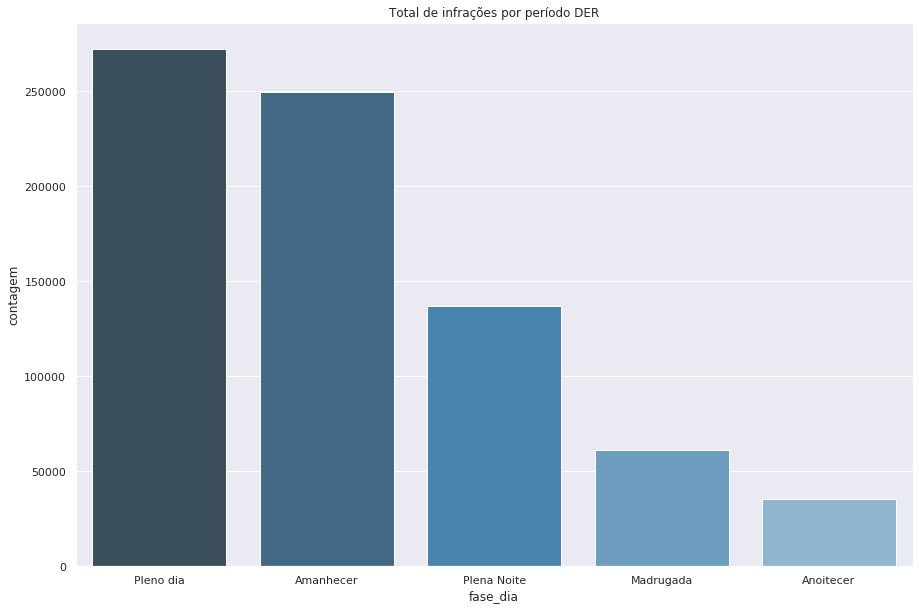

In [20]:
infracoes_por_periodo_der = df_infracoes_der_2018_2019.groupby('fase_dia').size().reset_index(name = 'contagem').\
                            sort_values('contagem', ascending = False)

sns.barplot(data = infracoes_por_periodo_der, x = 'fase_dia', y = 'contagem', palette = 'Blues_d')
plt.title('Total de infrações por período DER')

Text(0.5, 1.0, 'Total de infrações de limite de velocidade por período DER')

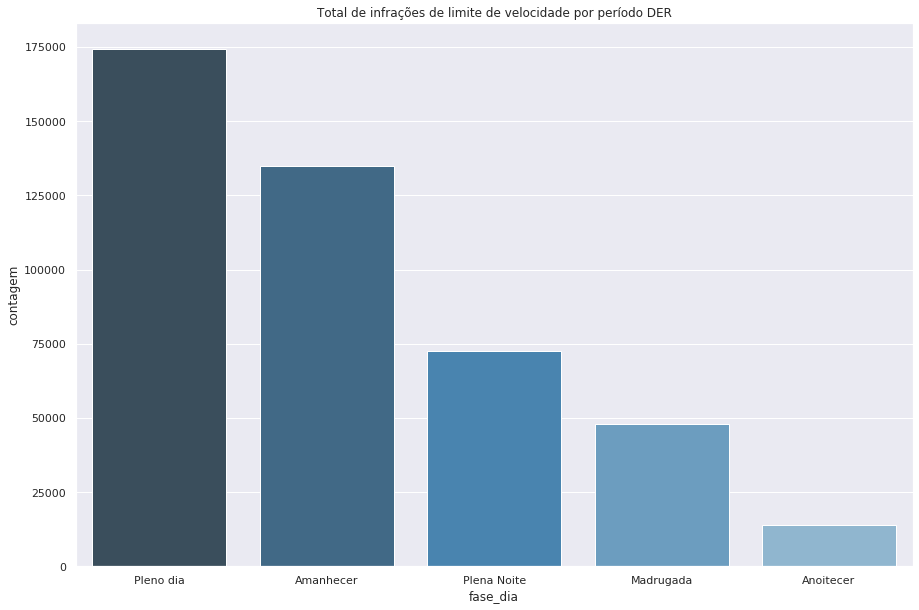

In [21]:
lista_infracoes_alta_velocidade = ['Transitar em velocidade superior à máxima permitida em até 20%', 'Transitar em velocidade superior à máxima permitida em mais de 20% até 50%', 'Transitar em velocidade superior à máxima permitida em mais de 50%']

infracoes_por_periodo_der = df_infracoes_der_2018_2019[df_infracoes_der_2018_2019.descricao.isin(lista_infracoes_alta_velocidade)]
infracoes_por_periodo_der = infracoes_por_periodo_der.groupby('fase_dia').size().reset_index(name = 'contagem').\
                            sort_values('contagem', ascending = False)

sns.barplot(data = infracoes_por_periodo_der, x = 'fase_dia', y = 'contagem', palette = 'Blues_d')
plt.title('Total de infrações de limite de velocidade por período DER')

Text(0.5, 1.0, 'Total de infrações ligadas ao álcool por período DER')

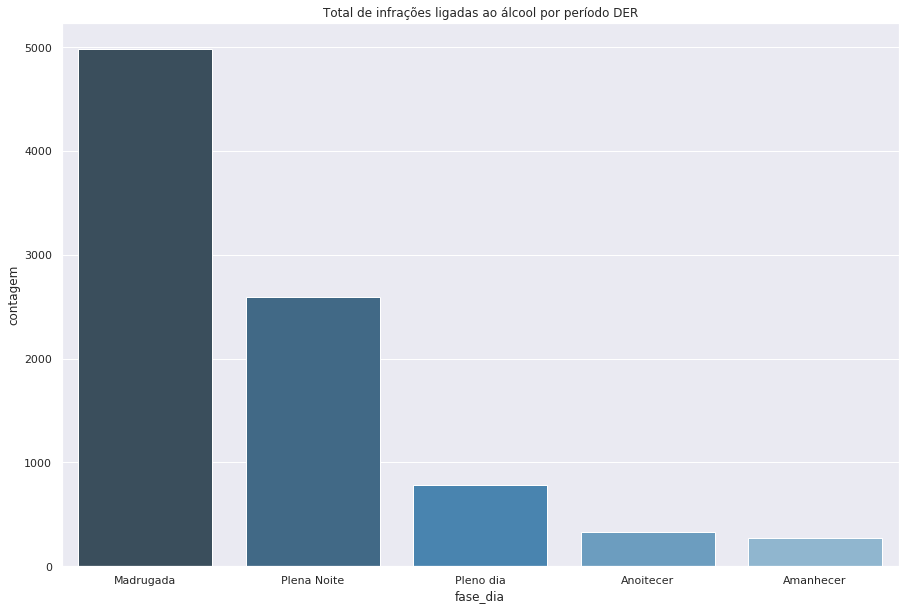

In [22]:
lista_infracoes_alcool = ['Recusar-se a ser submetido a teste, exame clínico, perícia ou outro procedimento que permita certificar influência de álcool ou outra substância psicoativa, na forma estabelecida pelo art. 277.', 'Dirigir sob a influência de álcool']

infracoes_por_periodo_der = df_infracoes_der_2018_2019[df_infracoes_der_2018_2019.descricao.isin(lista_infracoes_alcool)]
infracoes_por_periodo_der = infracoes_por_periodo_der.groupby('fase_dia').size().reset_index(name = 'contagem').\
                            sort_values('contagem', ascending = False)

sns.barplot(data = infracoes_por_periodo_der, x = 'fase_dia', y = 'contagem', palette = 'Blues_d')
plt.title('Total de infrações ligadas ao álcool por período DER')

Text(0.5, 1.0, 'Total de infrações ligadas ao álcool por período DER')

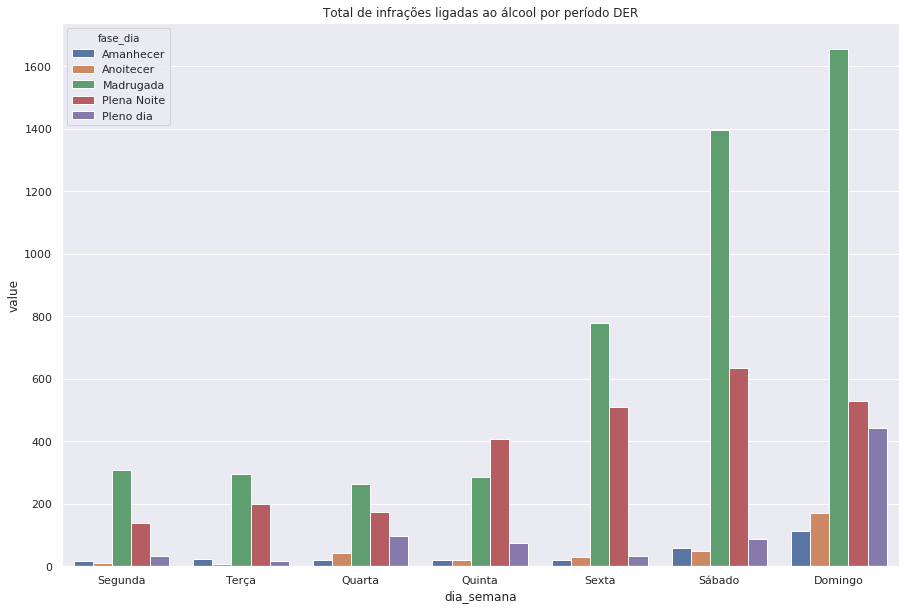

In [23]:
lista_infracoes_alcool = ['Recusar-se a ser submetido a teste, exame clínico, perícia ou outro procedimento que permita certificar influência de álcool ou outra substância psicoativa, na forma estabelecida pelo art. 277.', 'Dirigir sob a influência de álcool']

infracoes_por_periodo_der = df_infracoes_der_2018_2019[df_infracoes_der_2018_2019.descricao.isin(lista_infracoes_alcool)]
infracoes_por_periodo_der['dia_semana'] = df_infracoes_der_2018_2019.cometimento.dt.day_name()
infracoes_por_periodo_der = infracoes_por_periodo_der.groupby(['dia_semana', 'fase_dia']).size().unstack().reset_index()
infracoes_por_periodo_der = infracoes_por_periodo_der.melt(id_vars = ['dia_semana'], value_vars = ['Amanhecer', 'Anoitecer', 'Madrugada', 'Plena Noite', 'Pleno dia'])

infracoes_por_periodo_der.dia_semana = infracoes_por_periodo_der.dia_semana.replace({'Monday': 'Segunda', 'Tuesday': 'Terça', 'Wednesday': 'Quarta', 'Thursday': 'Quinta', 'Friday': 'Sexta', 'Saturday': 'Sábado', 'Sunday': 'Domingo'})
order_days = ['Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta', 'Sábado', 'Domingo']

sns.barplot(data = infracoes_por_periodo_der, x = 'dia_semana', y = 'value', hue = 'fase_dia', order = order_days)
plt.title('Total de infrações ligadas ao álcool por período DER')

### Observações (H 08)

* PRF:
    * Ao contrário da hipótese, os acidentes com vítimas fatais se concentram no período da noite
    * O período com maior número de acidentes fatais (plena noite) é também um dos períodos com menor número de infrações (falta de fiscalização?).
    * Período do anoitecer (onde ocorre tráfego intenso e congestionamento) tem o menor número de acidentes fatais registrados.

* DER:
    * O padrão de acidentes é semelhante ao da PRF, pois a concentração de acidentes fatais ocorre durante o período da noite.
    * Para os registros do DER o períodos com maior número de acidentes fatais (Plena noite) é um dos períodos com menor número de infrações registradas.
    * Principais infrações para o período da noite (que podem explicar as causas dos acidentes fatais) estão relacionadas ao desenvolvimento de altas velocidades e problemas de iluminação.

Text(0.5, 1.0, 'Total de acidentes fatais em rodovias por periodo')

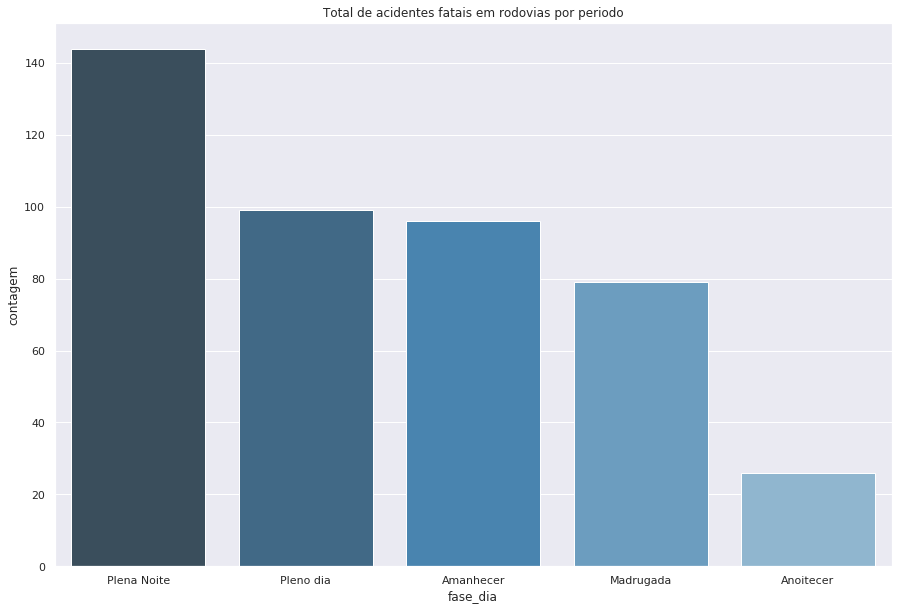

In [24]:
acidentes_rodovias_periodo = df_acidentes_rodovias_2010_2019.groupby('fase_dia').size().reset_index(name = 'contagem').\
                             sort_values('contagem', ascending = False)

sns.barplot(data = acidentes_rodovias_periodo, x = 'fase_dia', y = 'contagem', palette = 'Blues_d')
plt.title('Total de acidentes fatais em rodovias por periodo')

Text(0.5, 1.0, 'Boxplot do número de vítimas nos acidentes nos período da noite em rodovias')

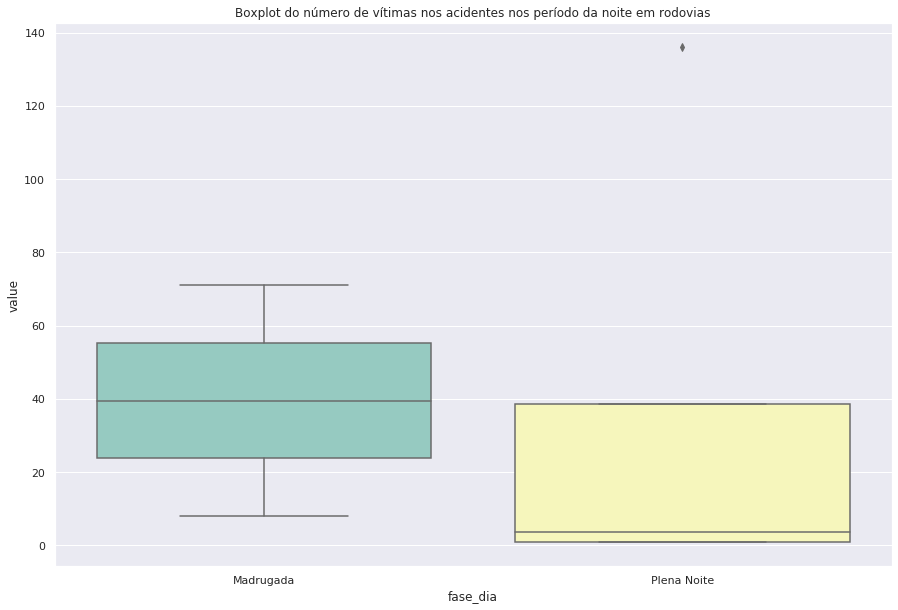

In [25]:
causas_acidentes_noite_rodovias = df_acidentes_rodovias_2010_2019[(df_acidentes_rodovias_2010_2019.fase_dia == 'Plena Noite')\
                                                                  | (df_acidentes_rodovias_2010_2019.fase_dia == 'Madrugada')]

causas_acidentes_noite_rodovias = causas_acidentes_noite_rodovias.groupby(['fase_dia', 'mortos']).size().\
                                  unstack().reset_index().melt(id_vars = ['fase_dia'], value_vars = [1, 2, 3, 4])

causas_acidentes_noite_rodovias = causas_acidentes_noite_rodovias.dropna()
sns.boxplot(data = causas_acidentes_noite_rodovias, x = 'fase_dia', y = 'value', palette = 'Set3')
plt.title('Boxplot do número de vítimas nos acidentes nos período da noite em rodovias')

Text(0.5, 1.0, 'Número de vítimas em acidentes no período da noite em rodovias')

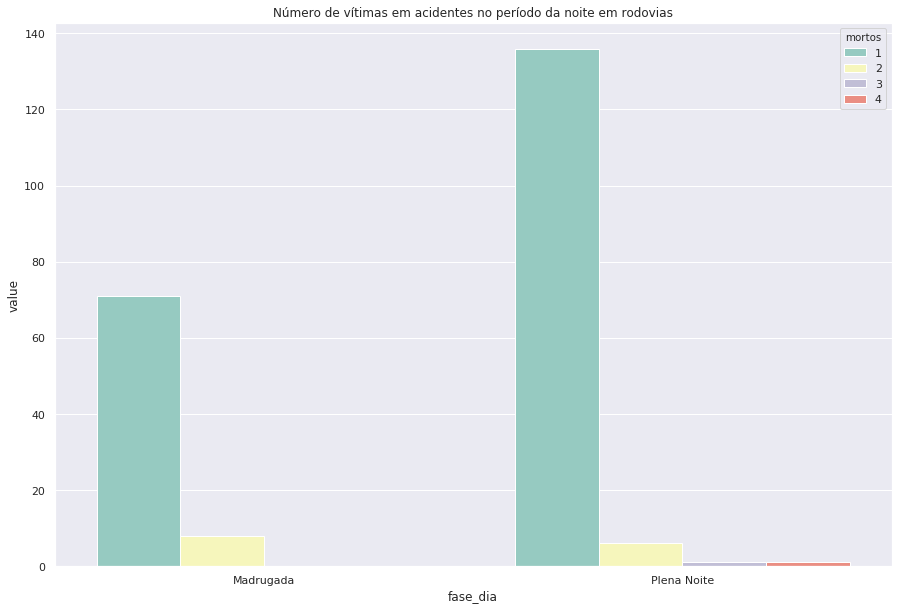

In [26]:
sns.barplot(data = causas_acidentes_noite_rodovias, x = 'fase_dia', y = 'value', hue = 'mortos', palette = 'Set3')
plt.title('Número de vítimas em acidentes no período da noite em rodovias')

Text(0.5, 1.0, 'Total de Acidentes (DER) por período')

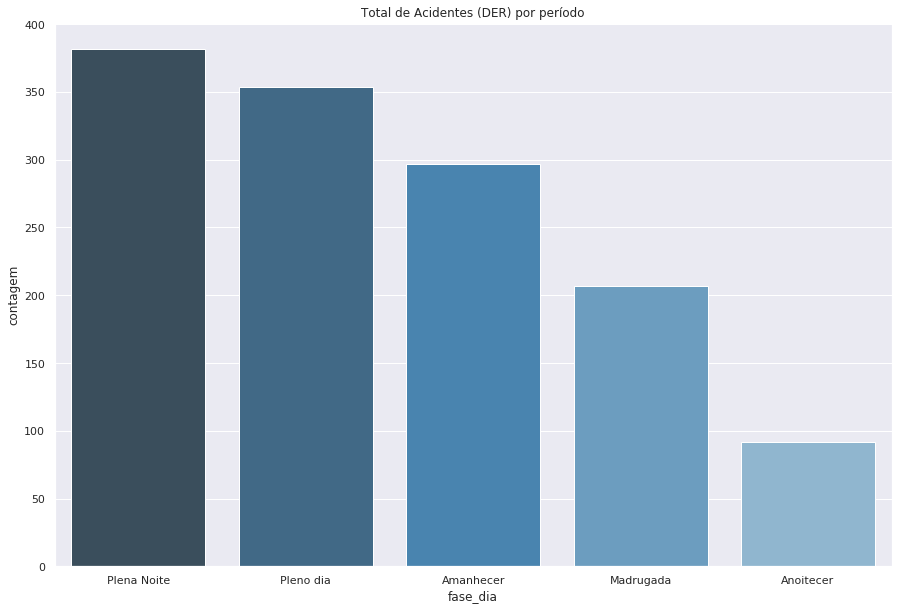

In [27]:
acidentes_periodo_der = df_acidentes_fatais_2008_2017.groupby('fase_dia').size().reset_index(name = 'contagem').\
                        sort_values('contagem', ascending = False)

sns.barplot(data = acidentes_periodo_der, x = 'fase_dia', y = 'contagem', palette = 'Blues_d')
plt.title('Total de Acidentes (DER) por período')

Text(0.5, 1.0, 'Frequência de infrações durante a noite')

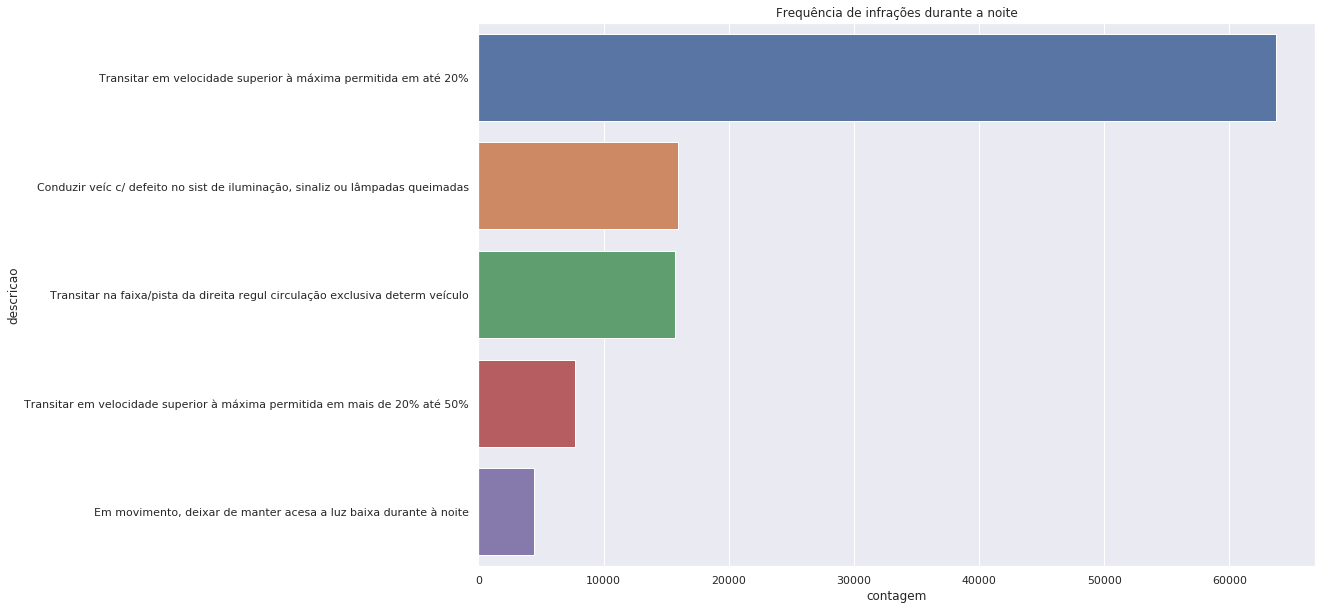

In [36]:
tipos_infracoes_noite_der = df_infracoes_der_2018_2019
tipos_infracoes_noite_der = tipos_infracoes_noite_der[tipos_infracoes_noite_der.fase_dia == 'Plena Noite']
tipos_infracoes_noite_der.descricao = tipos_infracoes_noite_der.descricao.str.strip()
tipos_infracoes_noite_der = tipos_infracoes_noite_der.groupby('descricao').size().reset_index(name = 'contagem').\
                            sort_values(by = 'contagem', ascending = False).head(n = 5)

sns.barplot(data = tipos_infracoes_noite_der, y = 'descricao', x = 'contagem')
plt.title("Frequência de infrações durante a noite")

Text(0.5, 1.0, 'Frequência de infrações durante a noite')

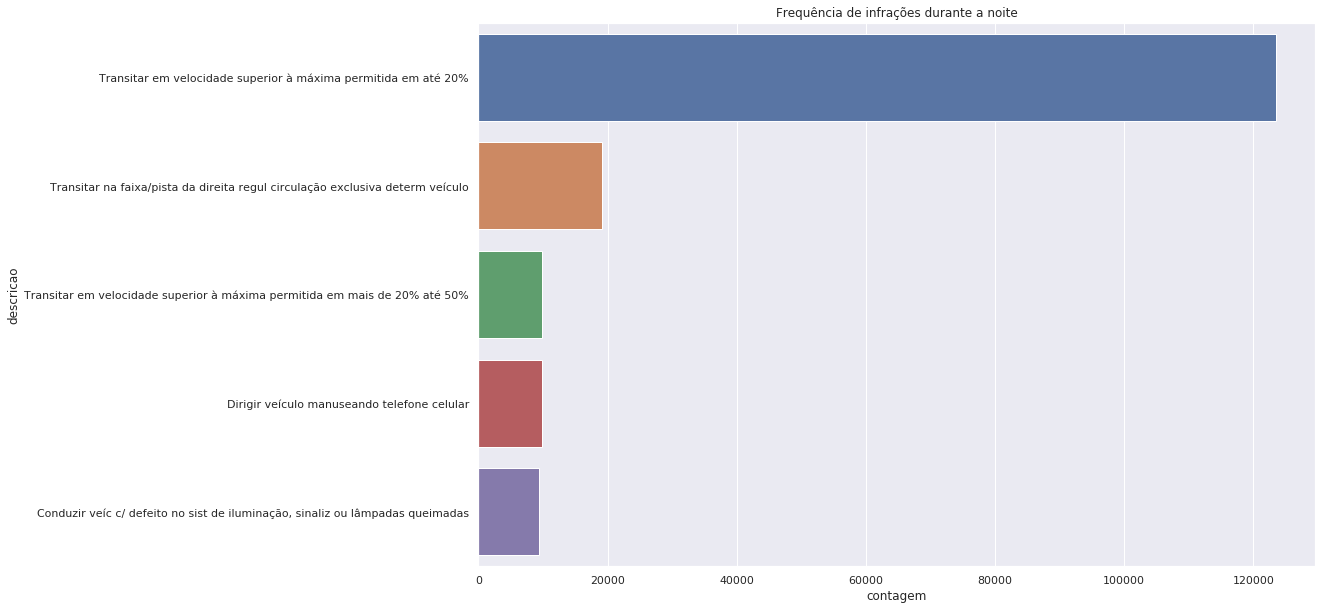

In [10]:
tipos_infracoes_amanhecer_der = df_infracoes_der_2018_2019
tipos_infracoes_amanhecer_der = tipos_infracoes_amanhecer_der[tipos_infracoes_amanhecer_der.fase_dia == 'Amanhecer']
tipos_infracoes_amanhecer_der.descricao = tipos_infracoes_amanhecer_der.descricao.str.strip()
tipos_infracoes_amanhecer_der = tipos_infracoes_amanhecer_der.groupby('descricao').size().reset_index(name = 'contagem').\
                            sort_values(by = 'contagem', ascending = False).head(n = 5)

sns.barplot(data = tipos_infracoes_amanhecer_der, y = 'descricao', x = 'contagem')
plt.title("Frequência de infrações durante a noite")

Text(0.5, 1.0, 'Frequência de infrações durante a noite')

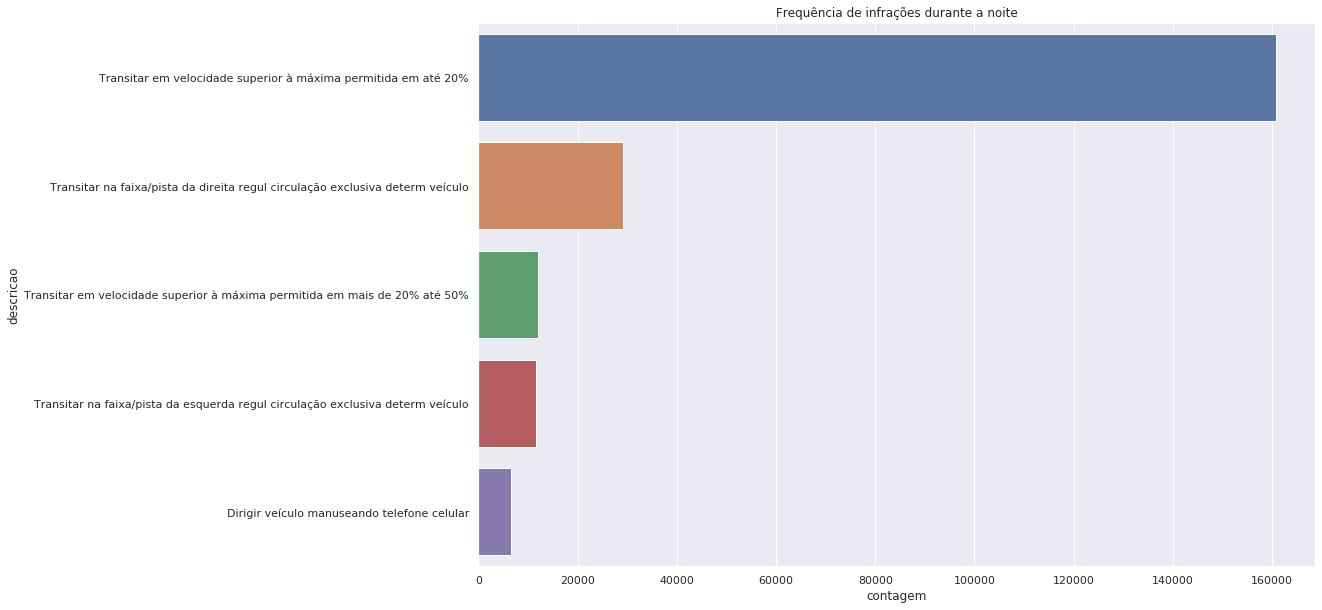

In [11]:
tipos_infracoes_dia_der = df_infracoes_der_2018_2019
tipos_infracoes_dia_der = tipos_infracoes_dia_der[tipos_infracoes_dia_der.fase_dia == 'Pleno dia']
tipos_infracoes_dia_der.descricao = tipos_infracoes_dia_der.descricao.str.strip()
tipos_infracoes_dia_der = tipos_infracoes_dia_der.groupby('descricao').size().reset_index(name = 'contagem').\
                            sort_values(by = 'contagem', ascending = False).head(n = 5)

sns.barplot(data = tipos_infracoes_dia_der, y = 'descricao', x = 'contagem')
plt.title("Frequência de infrações durante a noite")

Text(0.5, 1.0, 'Frequência de infrações durante a noite')

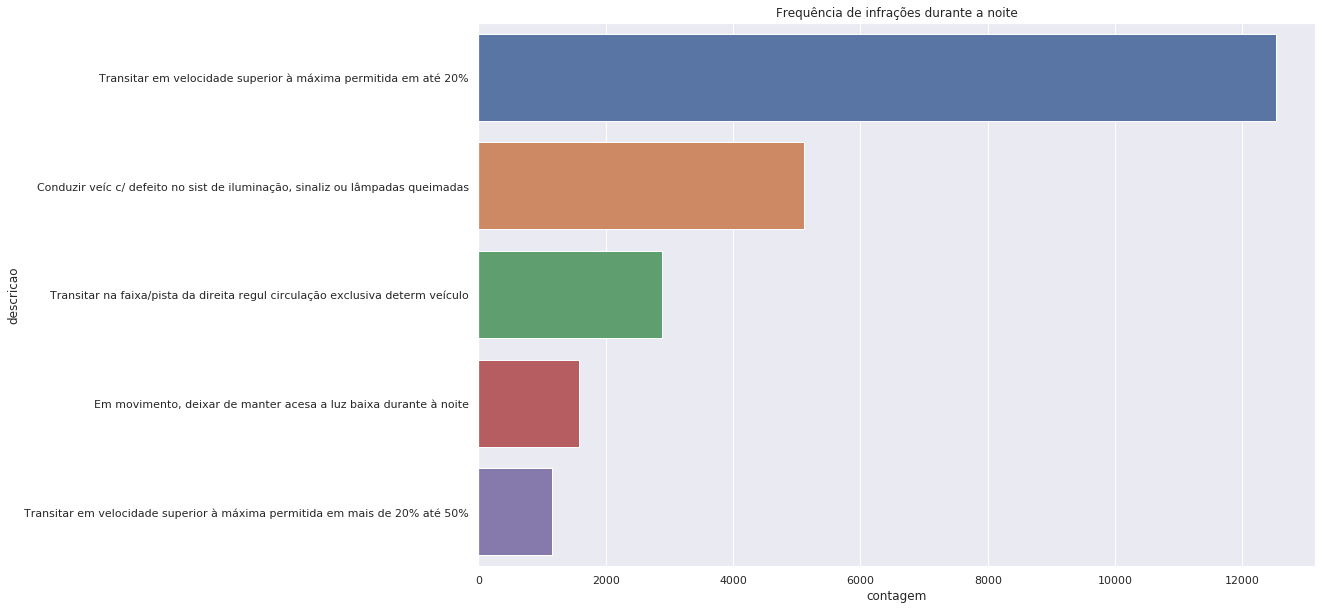

In [13]:
tipos_infracoes_anoitecer_der = df_infracoes_der_2018_2019
tipos_infracoes_anoitecer_der = tipos_infracoes_anoitecer_der[tipos_infracoes_anoitecer_der.fase_dia == 'Anoitecer']
tipos_infracoes_anoitecer_der.descricao = tipos_infracoes_anoitecer_der.descricao.str.strip()
tipos_infracoes_anoitecer_der = tipos_infracoes_anoitecer_der.groupby('descricao').size().reset_index(name = 'contagem').\
                            sort_values(by = 'contagem', ascending = False).head(n = 5)

sns.barplot(data = tipos_infracoes_anoitecer_der, y = 'descricao', x = 'contagem')
plt.title("Frequência de infrações durante a noite")